# ***Libraries Importing***

In [ ]:
!pip install netgraph

In [215]:
import networkx as nx
import time
import matplotlib.pyplot as plt
import igraph as ig
from networkx.algorithms import community as nx_comm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from community import community_louvain
import leidenalg as la

from sklearn.metrics.pairwise import cosine_similarity
import community as community_louvain
import plotly.graph_objects as go

import networkx as nx
import time
import matplotlib.pyplot as plt
import igraph as ig
from networkx.algorithms import community as nx_comm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from community import community_louvain
import leidenalg as la

from sklearn.metrics.pairwise import cosine_similarity
import community as community_louvain
import plotly.graph_objects as go



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import community

# ***Preprocessing***

In [ ]:
class Preprocessor:
    @staticmethod
    def preprocess_text(text):
        """
        Preprocesses text data by:
        1. Removing punctuation.
        2. Converting text to lowercase.
        3. Tokenizing text.
        4. Removing stop words.
        5. Lemmatizing tokens.

        Args:
        - text (str): Input text to preprocess.

        Returns:
        - str: Preprocessed text as a string.
        """
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Convert to lowercase
        text = text.lower()
        # Tokenize text
        tokens = word_tokenize(text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        # Perform lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Return preprocessed text as a string
        return ' '.join(lemmatized_tokens)

    @staticmethod
    def read_dblp_dataset(file_path):
        """
        Reads data from the DBLP dataset file and preprocesses it.

        Args:
        - file_path (str): Path to the DBLP dataset file.

        Returns:
        - list: List of dictionaries, each representing a preprocessed paper.
        """
        papers = []
        with open(file_path, 'r', encoding='utf-8') as file:
            paper = None
            references = ""  # Initialize references string
            for line in file:
                line = line.strip()
                if line.startswith("#*"):
                    title = line[2:]
                elif line.startswith("#@"):
                    authors = line[2:].split(',')
                elif line.startswith("#t"):
                    year = int(line[2:])
                elif line.startswith("#c"):
                    venue = line[2:]
                elif line.startswith("#index"):
                    index = int(line[6:])
                elif line.startswith("#%"):
                    references += line[2:] + ','  # Append reference ID to references string
                elif line.startswith("#!"):
                    abstract = line[2:]
                    abstract = Preprocessor.preprocess_text(abstract)  # Preprocess abstract
                    paper = {
                        'title': title,
                        'authors': authors,
                        'year': year,
                        'venue': venue,
                        'index': index,
                        'abstract': abstract,
                        'references': references[:-1]  # Remove trailing comma and store references string
                    }
                    papers.append(paper)
                    paper = None
                    references = ""  # Reset references string
        return papers

    @staticmethod
    def write_csv(papers, file_path):
        """
        Writes preprocessed paper data to a CSV file.

        Args:
        - papers (list): List of dictionaries, each representing a preprocessed paper.
        - file_path (str): Path to the CSV file to write.
        """
        with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['title', 'authors', 'year', 'venue', 'index', 'abstract', 'references']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for paper in papers:
                writer.writerow(paper)


In [ ]:
preprocessor = Preprocessor()

In [ ]:

file_path = '/content/drive/MyDrive/DBLP dataset/outputacm.txt'
papers = preprocessor.read_dblp_dataset(file_path)
csv_file_path = '/content/drive/MyDrive/DBLP dataset/dblp_dataset.csv'
preprocessor.write_csv(papers, csv_file_path)

In [ ]:
csv_file_path = '/content/drive/MyDrive/DBLP dataset/dblp_dataset.csv'

In [ ]:
data=pd.read_csv(csv_file_path)

In [ ]:
data.head()

,title,authors,year,venue,index,abstract,references
0,Performance engineering in industry: current p...,"['Ahmed E. Hassan', 'Parminder Flora']",2007,Proceedings of the 6th international workshop ...,2,panel session discus performance engineering p...,NaN
1,"Dude, You Can Do It! How to Build a Sweeet PC","['Darrel Creacy', 'Carlito Vicencio']",2005,NaN,3,whether youre frustrated current pc offering i...,NaN
2,Interpreting Kullback-Leibler divergence with ...,"['Shinto Eguchi', 'John Copas']",2006,Journal of Multivariate Analysis,5,kullbackleibler divergence neymanpearson lemma...,436405
3,TOPP---the OpenMS proteomics pipeline,"['Oliver Kohlbacher', 'Knut Reinert', 'Clemens...",2007,Bioinformatics,7,motivation experimental technique proteomics s...,NaN
4,"Webbots, Spiders, and Screen Scrapers","['Michael Schrenk', 'Michael Shrenk']",2007,NaN,12,internet bigger better mere browser allows web...,NaN


In [ ]:
data['references'].replace('[]', np.NaN, inplace=True)

In [ ]:
data.isnull().sum()

title              0
authors            0
year               0
venue          32024
index              0
abstract          15
references    170080
dtype: int64

In [ ]:
data.shape

(281080, 7)

In [ ]:
data.dropna(subset='venue',inplace=True)

In [ ]:
data.isnull().sum()

title              0
authors            0
year               0
venue              0
index              0
abstract           4
references    138525
dtype: int64

In [ ]:
data['references'].fillna(data['references'].mode()[0], inplace=True)


In [ ]:
data.dropna(subset='abstract',inplace=True)

In [ ]:
data.isnull().sum()

title         0
authors       0
year          0
venue         0
index         0
abstract      0
references    0
dtype: int64

In [ ]:
data.shape

(249052, 7)

In [ ]:
data.columns

Index(['title', 'authors', 'year', 'venue', 'index', 'abstract', 'references'], dtype='object')

In [ ]:
data['abstract'][0]

'panel session discus performance engineering practice industry presentation session explore use lightweight technique approach order permit cost effective rapid adoption performance modeling research large industrial software system'

In [ ]:
data

,title,authors,year,venue,index,abstract,references
0,Performance engineering in industry: current p...,"['Ahmed E. Hassan', 'Parminder Flora']",2007,Proceedings of the 6th international workshop ...,2,panel session discus performance engineering p...,246511
2,Interpreting Kullback-Leibler divergence with ...,"['Shinto Eguchi', 'John Copas']",2006,Journal of Multivariate Analysis,5,kullbackleibler divergence neymanpearson lemma...,436405
3,TOPP---the OpenMS proteomics pipeline,"['Oliver Kohlbacher', 'Knut Reinert', 'Clemens...",2007,Bioinformatics,7,motivation experimental technique proteomics s...,246511
5,Approximating fluid schedules in crossbar pack...,"['Michael Rosenblum', 'Constantine Caramanis',...",2006,IEEE/ACM Transactions on Networking (TON),17,consider problem motivated desire provide flex...,"357875,214023,317448,319987,334185,95255,29412..."
6,On product covering in 3-tier supply chain mod...,"['Jianer Chen', 'Fenghui Zhang']",2006,Theoretical Computer Science,24,field supply chain management growing rapid pa...,"251778,436906,623227,287885"
...,...,...,...,...,...,...,...
281075,Effectiveness and usability of an online help ...,"['Jérôme Simonin', 'Noëlle Carbonell', 'Daniel...",2008,Proceedings of the 10th international conferen...,629806,empirical study presented aim assessing possib...,"8543,327540,395578,397153,398612"
281076,Busy period analysis of finite QBD processes,"['Chaitanya Garikiparthi', 'Appie van de Liefv...",2008,ACM SIGMETRICS Performance Evaluation Review,629807,present number customer served length busy per...,340965
281077,The Grid as a Single Entity: Towards a Behavio...,"['Jesús Montes', 'Alberto Sánchez', 'Julio J. ...",2008,Proceedings of the OTM 2008 Confederated Inter...,629808,grid emerged last decade large distributed env...,246511
281078,Multimodal system evaluation using modality ef...,"['Manolis Perakakis', 'Alexandros Potamianos']",2008,Proceedings of the 10th international conferen...,629811,paper propose two new objective metric relativ...,"294663,302639,572828"


In [ ]:
df=data.copy().sample(frac=1).reset_index(drop=True)[:100]

In [ ]:
for i in range(len(df)):
  df['abstract'][i]=Preprocessor.preprocess_text(df['abstract'][i])

In [ ]:
df['abstract']

0     order solve feature reconstruction problem fmr...
1     vhdl standard currently allows concurrent acce...
2     today mobility persistence important aspect di...
3     article investigates effectiveness voting stac...
4     paper study capacity hybrid wireless network o...
                            ...                        
95    field evolutionary computation traditionally f...
96    paper investigates extraction machining featur...
97    bee colony optimization bco algorithm travelin...
98    article present overall characteristic method ...
99    perfect 2matching graph vector assigning value...
Name: abstract, Length: 100, dtype: object

In [202]:
!pip install networkx plotly python-louvain igraph leidenalg cdlib

In [214]:
!pip install networkx plotly


In [295]:
df.head()

,title,authors,year,venue,index,abstract,references,keywords,combined_text
0,Hierarchical Fast Clustering Method for fMRI F...,"['Xiaomin Li', 'Wei Lin', 'Shuanghua Huang']",2009,Proceedings of the 2009 Second International S...,18394,order solve feature reconstruction problem fmr...,246511,reconstruction hfcm time order feature fmri hi...,246511 reconstruction hfcm time order feature ...
1,Protected Shared Variables in VHDL: IEEE Stand...,"['Peter J. Ashenden', 'Philip A. Wilsey']",1999,IEEE Design Test,439681,vhdl standard currently allows concurrent acce...,"116882,242697,319232,332514,440464,480846",variable shared access type monitor protected ...,"116882,242697,319232,332514,440464,480846 vari..."
2,Making Java applications mobile or persistent,['Sara Bouchenak'],2001,Proceedings of the 6th conference on USENIX Co...,422138,today mobility persistence important aspect di...,182652,thread java service application dynamic mobili...,182652 thread java service application dynamic...
3,Combining Information Extraction Systems Using...,"['Georgios Sigletos', 'Georgios Paliouras', 'C...",2005,The Journal of Machine Learning Research,34020,article investigates effectiveness voting stac...,"601824,193940,329493,286105,590645,311093,4349...",baselevel stacking voting metalevel domain bet...,"601824,193940,329493,286105,590645,311093,4349..."
4,On the Capacity of Hybrid Wireless Networks wi...,"['Tan Le', 'Yong Liu']",2009,Proceedings of the 4th International Conferenc...,507794,paper study capacity hybrid wireless network o...,246511,network wireless routing opportunistic station...,246511 network wireless routing opportunistic ...


In [319]:
titles = df['keywords']

# Combine titles and keywords for vectorization
text_data = df['title']+''+df['references']
# Text processing and vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(text_data)

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [320]:
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.03083859, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.03458993,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03083859, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.03458993, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [323]:
# Create graph based on similarity
threshold = 0.02 # Adjust based on desired sensitivity
G = nx.Graph()
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if cosine_sim[i, j] >= threshold:
            G.add_edge(i, j, weight=cosine_sim[i, j])

In [324]:
# Compute 3D spring layout
pos = nx.spring_layout(G, dim=3)

# Extract node and edge positions
x_nodes = [pos[k][0] for k in pos]
y_nodes = [pos[k][1] for k in pos]
z_nodes = [pos[k][2] for k in pos]

edge_x = []
edge_y = []
edge_z = []

for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

# Create trace for edges
edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines')

# Create trace for nodes
node_trace = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(
        size=6,
        color='blue',
        opacity=0.8
    ),
    hoverinfo='text'
)

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Citation Network Graph in 3D',
                    showlegend=False,
                    scene=dict(
                        xaxis=dict(showbackground=False),
                        yaxis=dict(showbackground=False),
                        zaxis=dict(showbackground=False)
                    ),
                    margin=dict(b=0, l=0, r=0, t=40)
                ))

fig.show()


In [279]:
!pip install networkx python-louvain plotly


In [235]:
!pip install python-louvain

In [325]:



# Define community detection functions
def walktrap_communities(graph):
    start_time = time.time()
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}
    reverse_node_mapping = {i: node for node, i in node_mapping.items()}
    edges = [(node_mapping[u], node_mapping[v]) for u, v in graph.edges()]
    graph_ig = ig.Graph(edges, directed=False)
    walktrap_partition = graph_ig.community_walktrap().as_clustering()
    community_dict = {reverse_node_mapping[node]: i for i, community in enumerate(walktrap_partition) for node in community}
    community_partition = [list(map(reverse_node_mapping.get, comm)) for comm in walktrap_partition]
    end_time = time.time()
    execution_time = end_time - start_time
    return community_dict, community_partition, execution_time

def girvan_newman_communities(graph):
    start_time = time.time()
    communities_generator = nx_comm.girvan_newman(graph)
    next_level_communities = next(communities_generator, [])
    partition = {node: i for i, comm in enumerate(next_level_communities) for node in comm}
    end_time = time.time()
    execution_time = end_time - start_time
    return partition, list(next_level_communities), execution_time

def label_propagation_communities(graph):
    start_time = time.time()
    partition = nx_comm.asyn_lpa_communities(graph)
    partition_list = [list(community) for community in partition]
    partition_dict = {node: i for i, comm in enumerate(partition_list) for node in comm}
    end_time = time.time()
    execution_time = end_time - start_time
    return partition_dict, partition_list, execution_time

def louvain_communities(graph):
    start_time = time.time()
    partition = community_louvain.best_partition(graph)
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)
    end_time = time.time()
    execution_time = end_time - start_time
    return partition, list(communities.values()), execution_time

def leiden_communities(graph):
    start_time = time.time()
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}
    reverse_node_mapping = {i: node for node, i in node_mapping.items()}
    edges = [(node_mapping[u], node_mapping[v]) for u, v in graph.edges()]
    graph_ig = ig.Graph(edges, directed=False)
    leiden_partition = la.find_partition(graph_ig, la.ModularityVertexPartition)
    community_dict = {reverse_node_mapping[node]: i for i, community in enumerate(leiden_partition) for node in community}
    community_partition = [list(map(reverse_node_mapping.get, comm)) for comm in leiden_partition]
    end_time = time.time()
    execution_time = end_time - start_time
    return community_dict, community_partition, execution_time

In [326]:
# Function to calculate silhouette score
def calculate_silhouette(graph, communities):
    node_to_community = {node: community_id for community_id, community in enumerate(communities) for node in community}
    distances = dict(nx.all_pairs_shortest_path_length(graph))
    silhouette_scores = []
    for node in graph.nodes():
        if node not in node_to_community:
            continue
        community_id = node_to_community[node]
        intra_cluster_distances = []
        inter_cluster_distances = []
        for other_node in graph.nodes():
            if other_node == node:
                continue
            if other_node not in distances[node]:
                continue
            if node_to_community[other_node] == community_id:
                intra_cluster_distances.append(distances[node][other_node])
            else:
                inter_cluster_distances.append(distances[node][other_node])
        a = np.mean(intra_cluster_distances) if intra_cluster_distances else 0
        b = np.mean(inter_cluster_distances) if inter_cluster_distances else 0
        silhouette_score = (b - a) / max(a, b) if max(a, b) != 0 else 0
        silhouette_scores.append(silhouette_score)
    overall_silhouette_score = np.mean(silhouette_scores)
    return overall_silhouette_score

In [330]:
# Function to create 3D plot
def plot_3d_communities(graph, partition, titles):

    pos = nx.spring_layout(graph, dim=3)
    x_nodes = [pos[k][0] for k in pos]
    y_nodes = [pos[k][1] for k in pos]
    z_nodes = [pos[k][2] for k in pos]

    edge_x = []
    edge_y = []
    edge_z = []

    for edge in graph.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        line=dict(width=0.5, color='gray'),
        hoverinfo='none',
        mode='lines')

    node_trace = go.Scatter3d(
        x=x_nodes, y=y_nodes, z=z_nodes,
        mode='markers',
        marker=dict(
            size=6,
            color=[partition[node] for node in graph.nodes()],
            colorscale='Viridis',
            opacity=0.8
        ),
         hoverinfo='text',
        text=[f'Title: {df.iloc[node]["title"]}' for node in G.nodes()]
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=titles,
                        showlegend=False,
                        scene=dict(
                            xaxis=dict(showbackground=False),
                            yaxis=dict(showbackground=False),
                            zaxis=dict(showbackground=False)
                        ),
                        margin=dict(b=0, l=0, r=0, t=40)
                    ))

    fig.show()

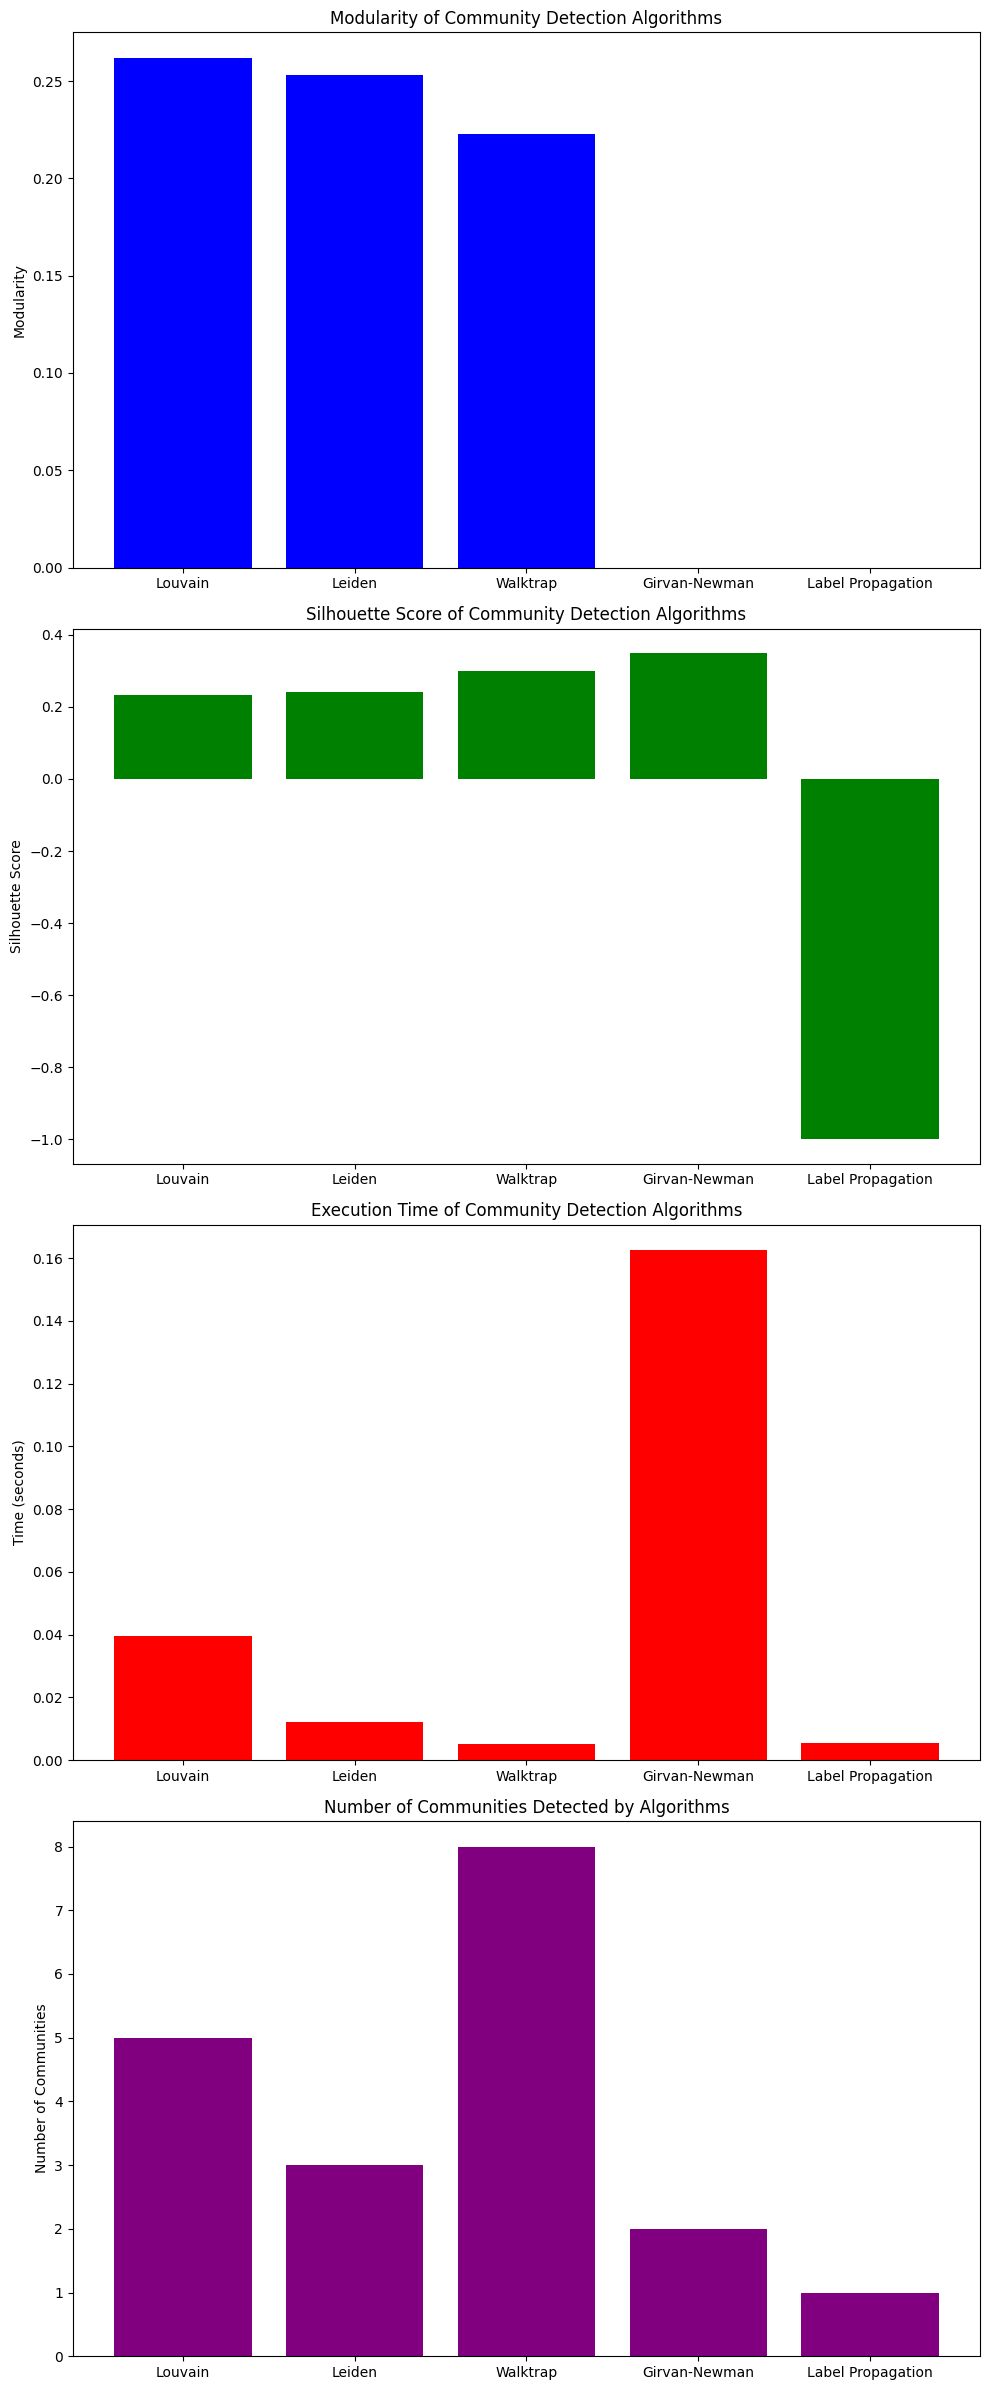

Louvain execution time: 0.0395 seconds, number of communities: 5
Leiden execution time: 0.0121 seconds, number of communities: 3
Walktrap execution time: 0.0050 seconds, number of communities: 8
Girvan-Newman execution time: 0.1625 seconds, number of communities: 2
Label Propagation execution time: 0.0054 seconds, number of communities: 1


In [334]:
# Compute and evaluate all algorithms
algorithms = {
    "Louvain": louvain_communities,
    "Leiden": leiden_communities,
    "Walktrap": walktrap_communities,
    "Girvan-Newman": girvan_newman_communities,
    "Label Propagation": label_propagation_communities
}

results = {}

for name, algorithm in algorithms.items():
    partition, communities, exec_time = algorithm(G)
    modularity = community_louvain.modularity(partition, G) if name != "Girvan-Newman" else nx_comm.modularity(G, communities)
    silhouette_score = calculate_silhouette(G, communities)
    num_communities = len(communities)
    results[name] = {
        "partition": partition,
        "communities": communities,
        "modularity": modularity,
        "silhouette": silhouette_score,
        "execution_time": exec_time,
        "num_communities": num_communities
    }
# Plot 3D community structures for all algorithms
for name in algorithms.keys():
    plot_3d_communities(G, results[name]["partition"], "louvain_communities")

# Plot evaluation results
evaluation_metrics = ['Modularity', 'Silhouette Score', 'Execution Time', 'Number of Communities']
fig, ax = plt.subplots(4, 1, figsize=(10, 24))

# Modularity
modularities = [results[algo]["modularity"] for algo in algorithms]
ax[0].bar(algorithms.keys(), modularities, color='blue')
ax[0].set_title('Modularity of Community Detection Algorithms')
ax[0].set_ylabel('Modularity')

# Silhouette Score
silhouette_scores = [results[algo]["silhouette"] for algo in algorithms]
ax[1].bar(algorithms.keys(), silhouette_scores, color='green')
ax[1].set_title('Silhouette Score of Community Detection Algorithms')
ax[1].set_ylabel('Silhouette Score')

# Execution Time
execution_times = [results[algo]["execution_time"] for algo in algorithms]
ax[2].bar(algorithms.keys(), execution_times, color='red')
ax[2].set_title('Execution Time of Community Detection Algorithms')
ax[2].set_ylabel('Time (seconds)')

# Number of Communities
num_communities = [results[algo]["num_communities"] for algo in algorithms]
ax[3].bar(algorithms.keys(), num_communities, color='purple')
ax[3].set_title('Number of Communities Detected by Algorithms')
ax[3].set_ylabel('Number of Communities')

plt.tight_layout()
plt.show()

# Print execution times and number of communities
for algo in algorithms:
    print(f"{algo} execution time: {results[algo]['execution_time']:.4f} seconds, number of communities: {results[algo]['num_communities']}")


In [335]:
for algo in algorithms:
    print(f"{algo} execution time: {results[algo]['execution_time']:.4f} seconds, "
          f"number of communities: {results[algo]['num_communities']}, "
          f"modularity: {results[algo]['modularity']:.4f}, "
          f"silhouette score: {results[algo]['silhouette']:.4f}")

Louvain execution time: 0.0395 seconds, number of communities: 5, modularity: 0.2620, silhouette score: 0.2316
Leiden execution time: 0.0121 seconds, number of communities: 3, modularity: 0.2533, silhouette score: 0.2417
Walktrap execution time: 0.0050 seconds, number of communities: 8, modularity: 0.2229, silhouette score: 0.3004
Girvan-Newman execution time: 0.1625 seconds, number of communities: 2, modularity: -0.0000, silhouette score: 0.3497
Label Propagation execution time: 0.0054 seconds, number of communities: 1, modularity: -0.0000, silhouette score: -1.0000
